# Feature inspection (fixation and saccade count)

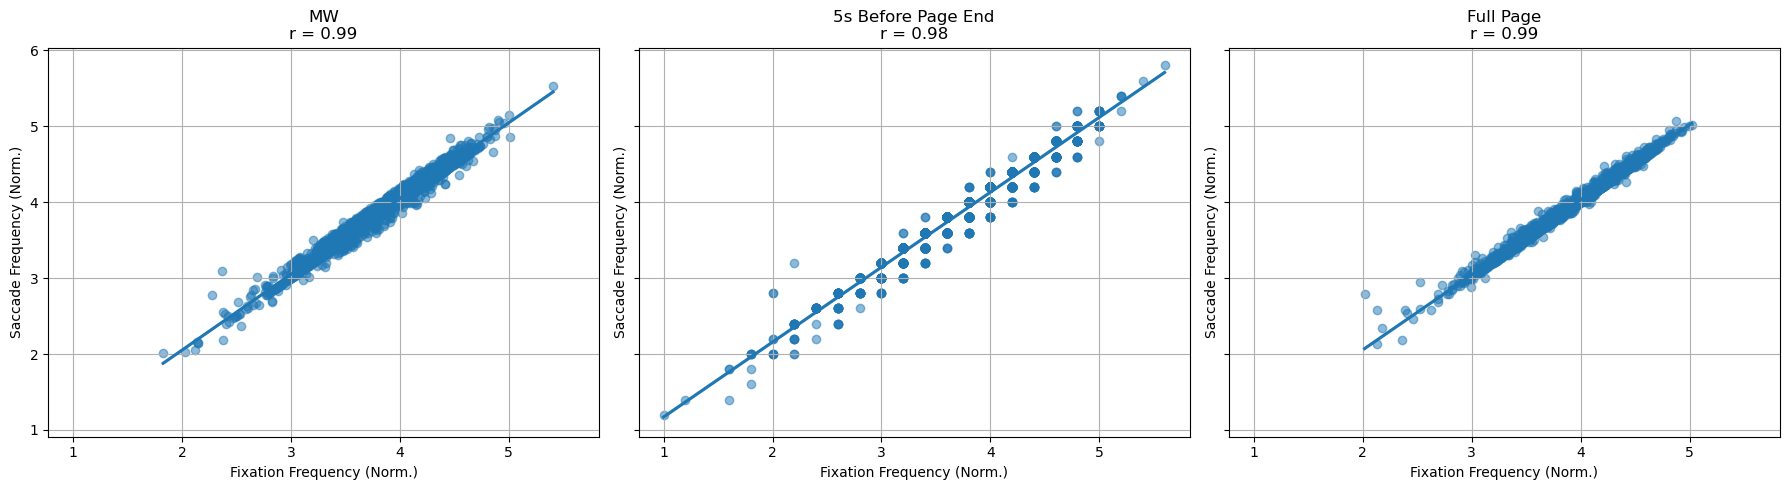

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# File info
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_names = {
    "MW": "group_features_mw_fixed_sr.csv",
    "5s Before Page End": "group_features_end5_sr.csv",
    "Full Page": "group_features_page_fixed_sr.csv"
}

cols = ['norm_fix_word_num', 'norm_sacc_num']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, (title, file_name) in zip(axes, file_names.items()):
    file_path = os.path.join(path, file_name)
    df = pd.read_csv(file_path)
    df = df[df['win_dur'] >= 5]

    if all(col in df.columns for col in cols):
        data = df[cols].dropna()
        corr = data.corr().iloc[0, 1]

        sns.regplot(
            data=data,
            x='norm_fix_word_num',
            y='norm_sacc_num',
            ax=ax,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'tab:blue'}
        )
        ax.set_title(f"{title}\nr = {corr:.2f}")
        ax.set_xlabel("Fixation Frequency (Norm.)")
        ax.set_ylabel("Saccade Frequency (Norm.)")
        ax.grid(True)
    else:
        ax.set_visible(False)
        print(f"Missing columns in {file_name}")

plt.tight_layout()
plt.show()



# Compare different classifier

Text(0.5, 1.0, 'ROC Curve')

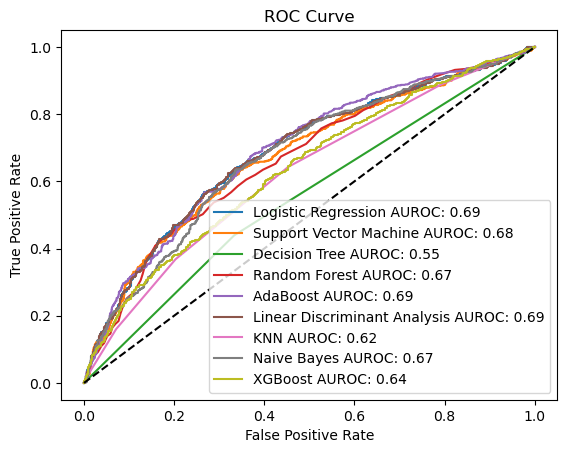

In [43]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, f1_score, recall_score, accuracy_score

def supervised_ml_pipeline(data, model, features):
    # Prepare the cross-validation strategy (Leave-One-Subject-Out)
    logo = LeaveOneGroupOut()

    # Extract features, labels, and subject IDs
    X = data[features].values
    y = data['label'].values
    groups = data['sub_id'].values

    # Initialize lists to store results
    acc_scores, f1_scores, recall_scores, auroc_scores = [], [], [], []
    all_confusion_matrices, true_labels, predicted_probs = [], [], []
    
    # Leave-one-subject-out cross-validation
    for train_idx, test_idx in logo.split(X, y, groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Default Model (without hyperparameter tuning)
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", model)  # Default parameters
        ])
        pipeline.fit(X_train, y_train)

        y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
        y_pred = pipeline.predict(X_test)

        # Compute metrics
        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        auroc_scores.append(roc_auc_score(y_test, y_pred_prob))

        # Store confusion matrix, true labels, and predicted probabilities
        all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
        true_labels.extend(y_test)
        predicted_probs.extend(y_pred_prob)

    return acc_scores, f1_scores, recall_scores, auroc_scores, all_confusion_matrices, true_labels, predicted_probs


def plot_roc(true_labels, predicted_probs):
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(true_labels, predicted_probs):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")


# define models
models = {
        'Logistic Regression': LogisticRegression(),
        'Support Vector Machine': SVC(probability=True),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'AdaBoost': AdaBoostClassifier(algorithm='SAMME'),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
        'KNN': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB(),
        'XGBoost': XGBClassifier()
    }

# Store All Metrics
all_metrics = []

# Load dataset
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = "group_features_mw_fixed_sr.csv"
file_path = os.path.join(path, file_name)
df = pd.read_csv(file_path)
df = df[df['win_dur']>=5]

# Define features
features = [
        "norm_sacc_num", "norm_in_word_reg", "norm_out_word_reg",
        "zscored_zipf_fixdur_corr", "zscored_word_length_fixdur_corr",
        "norm_total_viewing", 'fix_dispersion', 
        'weighted_vergence', "pupil_slope", "norm_pupil"
    ]

df["label"] = df["is_MWreported"]
data = df.dropna(subset=features)

# results dict
acc_scores_dict = {model_name: [] for model_name in models}
f1_scores_dict = {model_name: [] for model_name in models}
recall_scores_dict = {model_name: [] for model_name in models}
auroc_scores_dict = {model_name: [] for model_name in models}
all_confusion_matrices_dict = {model_name: [] for model_name in models}
true_labels_dict = {model_name: [] for model_name in models}
predicted_probs_dict = {model_name: [] for model_name in models}


# run ML
for model_name, model in models.items():
    acc_scores, f1_scores, recall_scores, auroc_scores, all_confusion_matrices, true_labels, predicted_probs = supervised_ml_pipeline(data, model, features)
    acc_scores_dict[model_name] = acc_scores
    f1_scores_dict[model_name] = f1_scores
    recall_scores_dict[model_name] = recall_scores
    auroc_scores_dict[model_name] = auroc_scores
    all_confusion_matrices_dict[model_name] = all_confusion_matrices
    true_labels_dict[model_name] = true_labels
    predicted_probs_dict[model_name] = predicted_probs

# Create a DataFrame to store model performance metrics
df_metrics = pd.DataFrame({
    "Model": np.repeat(list(models.keys()), [len(acc_scores_dict[m]) for m in models]),
    "Fold": [i for m in models for i in range(len(acc_scores_dict[m]))],
    "Accuracy": [score for m in models for score in acc_scores_dict[m]],
    "F1-score": [score for m in models for score in f1_scores_dict[m]],
    "Recall": [score for m in models for score in recall_scores_dict[m]],
    "AUROC": [score for m in models for score in auroc_scores_dict[m]]
})

#Plot ROC
# bold_leg = []
# index = 0
for model_name, _ in models.items():
    true_labels = true_labels_dict[model_name]
    predicted_probs = predicted_probs_dict[model_name]
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    auroc_score = roc_auc_score(true_labels, predicted_probs)
    # if auroc_score > 0.8:
    #     bold_leg.append(index)
    # index += 1
    plt.plot(fpr, tpr, label=f'{model_name} AUROC: {auroc_score:.2f}')

# annotate
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title(f'ROC Curve')

# Plot Feature Importance
# # Random Forest
# model = models['Random Forest']
# # Get feature importance
# importances = model.feature_importances_
# indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order
# # Plot feature importance
# plt.figure(figsize=(12, 10))
# plt.title("Random Forest Feature Importance")
# plt.bar(range(len(features)), importances[indices], align="center")
# plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45, ha='right')
# plt.ylabel('Weight')
# plt.show()

# # XGBoost
# model = models['XGBoost']
# # Get feature importance
# importances = model.feature_importances_
# indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order
# # Plot feature importance
# plt.figure(figsize=(12, 10))
# plt.title("XGBoost Feature Importance")
# plt.bar(range(len(features)), importances[indices], align="center")
# plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45, ha='right')
# plt.ylabel('Weight')
# plt.show()

# # Navie Bayes
# model = models['Naive Bayes']
# # Get the log probabilities
# log_prob = model.feature_log_prob_
# # Calculate feature importance as the sum of log probabilities across classes
# importance = np.sum(log_prob, axis=0)
# indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order
# # Plot feature importance
# plt.figure(figsize=(12, 10))
# plt.title("Naive Bayes Feature Importance")
# plt.bar(range(len(features)), importances[indices], align="center")
# plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45, ha='right')
# plt.ylabel('Weight')
# plt.show()

# # %% Plot Time Distribution
# df_cleaned['win_label'] = df_cleaned['label'].replace({True: 'MR', False: 'NR'})
# plt.figure()
# sns.histplot(data=df_cleaned, x='win_dur', hue='win_label', kde=True)

# Compare different window types

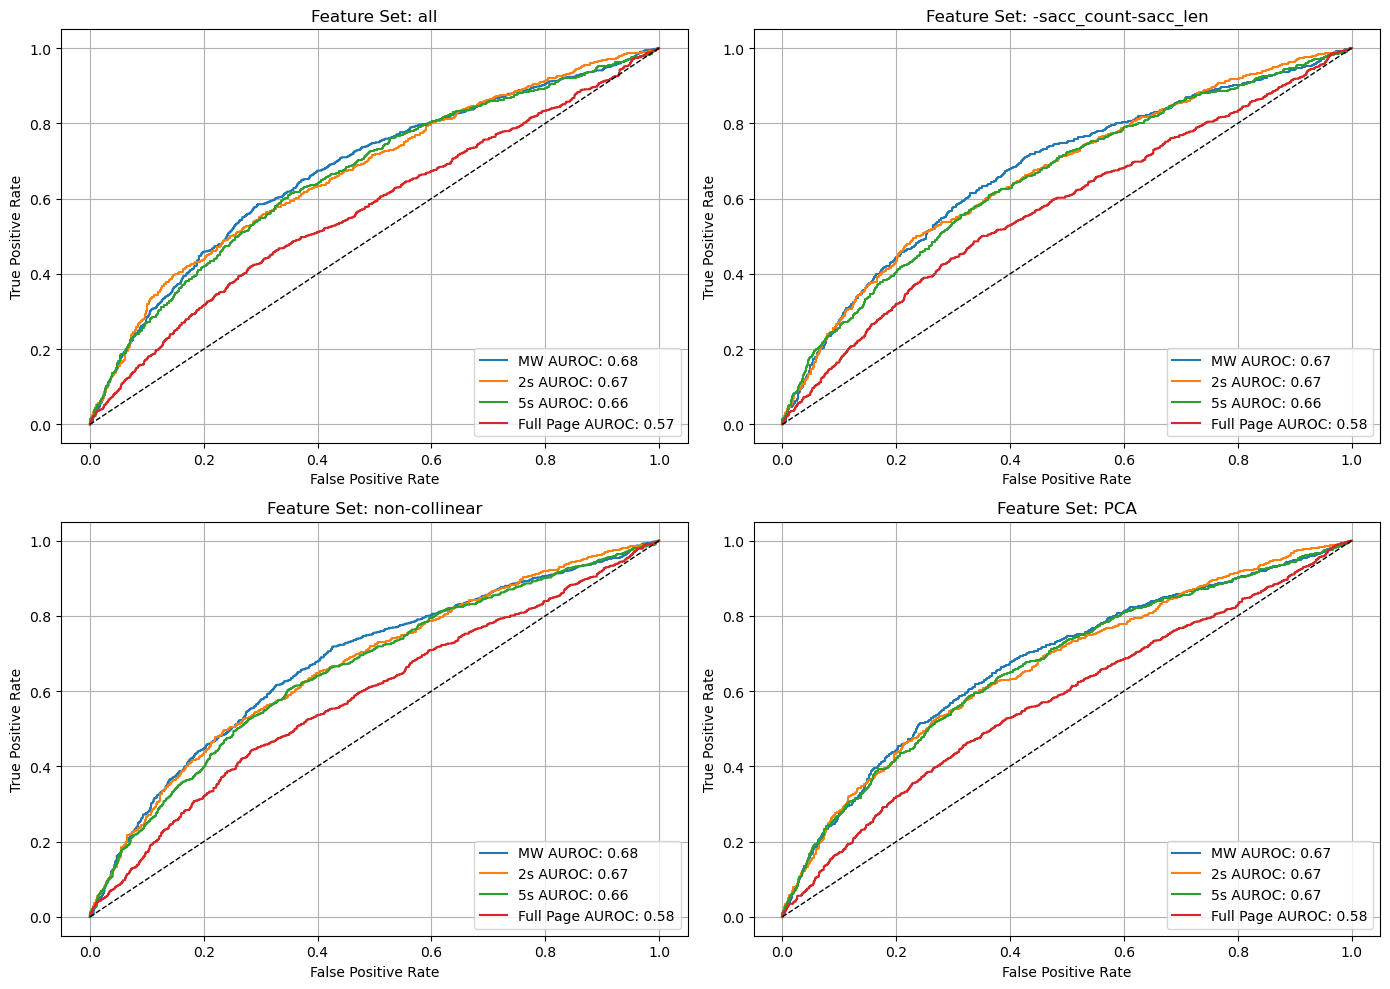

In [6]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, f1_score, recall_score, accuracy_score
from sklearn.decomposition import PCA

def supervised_ml_pipeline(data, model, features, use_pca=False):
    logo = LeaveOneGroupOut()
    X = data[features].values
    y = data['label'].values
    groups = data['sub_id'].values

    true_labels, predicted_probs = [], []

    for train_idx, test_idx in logo.split(X, y, groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        steps = [("scaler", StandardScaler())]
        if use_pca:
            steps.append(("pca", PCA(n_components=0.95)))  # keep 95% variance
        steps.append(("classifier", model))

        pipeline = Pipeline(steps)
        pipeline.fit(X_train, y_train)

        y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
        true_labels.extend(y_test)
        predicted_probs.extend(y_pred_prob)

    return true_labels, predicted_probs

# Load dataset
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_names = {
    "MW": "group_features_mw_fixed_sr.csv",
    "2s": "group_features_end2_sr.csv",
    "5s": "group_features_end5_sr.csv",
    "Full Page": "group_features_page_fixed_sr.csv"
}

# Feature sets
feature_sets = {
    "all": [
        "norm_fix_word_num", "norm_sacc_num", "norm_in_word_reg", "norm_out_word_reg",
        "zscored_zipf_fixdur_corr", "zscored_word_length_fixdur_corr",
        "norm_total_viewing", 'fix_dispersion', 'sacc_length', 
        'weighted_vergence', "pupil_slope", "norm_pupil"
    ],

    "-sacc_count-sacc_len":[
        "norm_fix_word_num", "norm_in_word_reg", "norm_out_word_reg",
        "zscored_zipf_fixdur_corr", "zscored_word_length_fixdur_corr",
        "norm_total_viewing", 'fix_dispersion', 
        'weighted_vergence', "pupil_slope", "norm_pupil"
    ],

    "non-collinear": [
        "norm_fix_word_num", "norm_in_word_reg", "norm_out_word_reg",
        "zscored_zipf_fixdur_corr", 'fix_dispersion', 
        'weighted_vergence', "pupil_slope", "norm_pupil"
    ],

    "PCA": [
        "norm_fix_word_num", "norm_sacc_num", "norm_in_word_reg", "norm_out_word_reg",
        "zscored_zipf_fixdur_corr", "zscored_word_length_fixdur_corr",
        "norm_total_viewing", 'fix_dispersion', 'sacc_length', 
        'weighted_vergence', "pupil_slope", "norm_pupil"
    ]
}

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (set_name, features) in enumerate(feature_sets.items()):
    ax = axes[idx]
    use_pca = (set_name == "PCA")

    for label, file_name in file_names.items():
        file_path = os.path.join(path, file_name)
        df = pd.read_csv(file_path)
        # df = df[df['win_dur'] >= 2]
        df["label"] = df["is_MWreported"]

        data = df.dropna(subset=features)
        y_true, y_score = supervised_ml_pipeline(data, LogisticRegression(), features, use_pca=use_pca)

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auroc = roc_auc_score(y_true, y_score)

        ax.plot(fpr, tpr, label=f'{label} AUROC: {auroc:.2f}')

    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_title(f'Feature Set: {set_name}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    ax.grid(True)

plt.tight_layout()
plt.show()




# Comparison to previous studies (permutation test on AUROC)

In [17]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, f1_score, recall_score, accuracy_score
# import warnings
# from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
def supervised_ml_pipeline(data, model, features):
    # Prepare the cross-validation strategy (Leave-One-Subject-Out)
    logo = LeaveOneGroupOut()

    # Extract features, labels, and subject IDs
    X = data[features].values
    y = data['label'].values
    groups = data['sub_id'].values

    # Initialize lists to store results
    
    true_labels, predicted_probs = [], []
    
    # Leave-one-subject-out cross-validation
    for train_idx, test_idx in logo.split(X, y, groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Default Model (without hyperparameter tuning)
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", model)  # Default parameters
        ])
        pipeline.fit(X_train, y_train)

        y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
        y_pred = pipeline.predict(X_test)

        # Store confusion matrix, true labels, and predicted probabilities
        true_labels.extend(y_test)
        predicted_probs.extend(y_pred_prob)

    return true_labels, predicted_probs


def permutation_test(df1, df2, n_permutations=200):
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Define features
    features = [
        "norm_fix_word_num", "norm_in_word_reg", "norm_out_word_reg",
        "zscored_zipf_fixdur_corr", 'fix_dispersion', 
        'weighted_vergence', "pupil_slope", "norm_pupil"
    ]
    
    df1['label'] = df1['is_MWreported']
    df1 = df1.dropna(subset=features)
    # df1 = df1[df1['win_dur'] >= 5]

    df2['label'] = df2['is_MWreported']
    df2 = df2.dropna(subset=features)
    # df2 = df2[df2['win_dur'] >= 5]
    
    # Get the actual AUROC difference between the two datasets
    true_labels1, predicted_probs1 = supervised_ml_pipeline(df1, LogisticRegression(), features=features)
    auroc_score1 = roc_auc_score(true_labels1, predicted_probs1)
    df1_auroc = auroc_score1

    true_labels2, predicted_probs2 = supervised_ml_pipeline(df2, LogisticRegression(), features=features)
    auroc_score2 = roc_auc_score(true_labels2, predicted_probs2)
    df2_auroc = auroc_score2

    real_auroc_diff = auroc_score1 - auroc_score2
    
    # List to store AUROC differences from the permutations
    auroc_dist = []

    for _ in tqdm(range(n_permutations), desc="Permutation Progress", unit="permutation"):
        # Shuffle labels for df1
        df_shuffled1 = df1.copy()
        df_shuffled1['label'] = np.random.permutation(df_shuffled1['label'].values)

        # Shuffle labels for df2
        df_shuffled2 = df2.copy()
        df_shuffled2['label'] = np.random.permutation(df_shuffled2['label'].values)

        # Get the AUROC scores for shuffled df1
        true_labels1, predicted_probs1 = supervised_ml_pipeline(df_shuffled1, LogisticRegression(max_iter=100), features=features)
        auroc_score1 = roc_auc_score(true_labels1, predicted_probs1)

        # Get the AUROC scores for shuffled df2
        true_labels2, predicted_probs2 = supervised_ml_pipeline(df_shuffled2, LogisticRegression(max_iter=100), features=features)
        auroc_score2 = roc_auc_score(true_labels2, predicted_probs2)

        # Calculate the AUROC difference for the current permutation
        auroc_dist.append(auroc_score1 - auroc_score2)

    # Compute the p-value (fraction of AUROC differences >= real AUROC difference)
    p_value = np.mean(np.array(auroc_dist) >= real_auroc_diff)

    # Return the null distribution of AUROC differences and the p-value
    return df1_auroc, df2_auroc, auroc_dist, real_auroc_diff, p_value


path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"

tasks = []
wins = []
df1_aurocs = []
df2_aurocs = []
auroc_distributions = []  # To store AUROC distributions
real_auroc_diffs = []  # To store real AUROC differences
p_values = []  # To store p-values

for task_type in ['sr', 'tp']:
    file_name = f'group_features_mw_fixed_{task_type}.csv'
    file_path = os.path.join(path, file_name)
    df1 = pd.read_csv(file_path)

    win_types = ['end2', 'end5', 'page_fixed']

    for win_type in win_types:
        file_name = f'group_features_{win_type}_{task_type}.csv'
        file_path = os.path.join(path, file_name)
        df2 = pd.read_csv(file_path)

        print(f"Task Type: {task_type}")
        print(f"Window Type: {win_type}")
        df1_auroc, df2_auroc, auroc_dist, real_auroc_diff, p_value = permutation_test(df1, df2)

        # Append results
        tasks.append(task_type)
        wins.append(win_type)
        df1_aurocs.append(df1_auroc)
        df2_aurocs.append(df2_auroc)
        auroc_distributions.append(auroc_dist)
        real_auroc_diffs.append(real_auroc_diff)
        p_values.append(p_value)

        print(f"{win_type}: p-value = {p_value:.4f}")

# Save results for the current folder (SRFiles or TPFiles)
results = {
    "task_type": tasks,
    "win_type": wins,
    "df1_auroc": df1_aurocs,
    "df2_auroc": df2_aurocs,
    "real_auroc_diff": real_auroc_diffs,
    "p_value": p_values,
    "auroc_distribution": auroc_distributions
}

# Save the results as a DataFrame
df_results = pd.DataFrame(results)

# # Save as CSV
output_file_path = os.path.join(path, "comparison_permutation_test_results.csv")
df_results.to_csv(output_file_path, index=False)
    





Task Type: sr
Window Type: end2


Permutation Progress: 100%|██████████| 200/200 [00:49<00:00,  4.03permutation/s]


end2: p-value = 0.1500
Task Type: sr
Window Type: end5


Permutation Progress: 100%|██████████| 200/200 [00:48<00:00,  4.11permutation/s]


end5: p-value = 0.3500
Task Type: sr
Window Type: page_fixed


Permutation Progress: 100%|██████████| 200/200 [00:50<00:00,  3.99permutation/s]


page_fixed: p-value = 0.0000
Task Type: tp
Window Type: end2


Permutation Progress: 100%|██████████| 200/200 [00:45<00:00,  4.43permutation/s]


end2: p-value = 0.0050
Task Type: tp
Window Type: end5


Permutation Progress: 100%|██████████| 200/200 [00:45<00:00,  4.37permutation/s]


end5: p-value = 0.0300
Task Type: tp
Window Type: page_fixed


Permutation Progress: 100%|██████████| 200/200 [00:45<00:00,  4.35permutation/s]


page_fixed: p-value = 0.0750


# GridSearch on Logistic Regression

Outer LOSO CV Progress:   2%|▏         | 1/47 [00:14<11:20, 14.80s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:   4%|▍         | 2/47 [00:29<11:15, 15.02s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:   6%|▋         | 3/47 [00:44<10:53, 14.84s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:   9%|▊         | 4/47 [00:59<10:43, 14.97s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


Outer LOSO CV Progress:  11%|█         | 5/47 [01:14<10:29, 14.98s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  13%|█▎        | 6/47 [01:28<09:55, 14.52s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  15%|█▍        | 7/47 [01:42<09:31, 14.29s/it]

{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


Outer LOSO CV Progress:  17%|█▋        | 8/47 [01:56<09:15, 14.23s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


Outer LOSO CV Progress:  19%|█▉        | 9/47 [02:11<09:06, 14.37s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  21%|██▏       | 10/47 [02:25<08:55, 14.46s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  23%|██▎       | 11/47 [02:39<08:33, 14.27s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  26%|██▌       | 12/47 [02:52<08:07, 13.92s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}


Outer LOSO CV Progress:  28%|██▊       | 13/47 [03:04<07:28, 13.21s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  30%|██▉       | 14/47 [03:17<07:20, 13.36s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  32%|███▏      | 15/47 [03:31<07:07, 13.36s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  34%|███▍      | 16/47 [03:44<06:53, 13.33s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  36%|███▌      | 17/47 [03:58<06:42, 13.41s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


Outer LOSO CV Progress:  38%|███▊      | 18/47 [04:11<06:27, 13.38s/it]

{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  40%|████      | 19/47 [04:24<06:15, 13.42s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  43%|████▎     | 20/47 [04:38<06:01, 13.39s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  45%|████▍     | 21/47 [04:51<05:49, 13.44s/it]

{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


Outer LOSO CV Progress:  47%|████▋     | 22/47 [05:05<05:39, 13.59s/it]

{'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  49%|████▉     | 23/47 [05:19<05:24, 13.53s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  51%|█████     | 24/47 [05:32<05:09, 13.44s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  53%|█████▎    | 25/47 [05:45<04:53, 13.35s/it]

{'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


Outer LOSO CV Progress:  55%|█████▌    | 26/47 [05:58<04:39, 13.31s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


Outer LOSO CV Progress:  57%|█████▋    | 27/47 [06:11<04:25, 13.26s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  60%|█████▉    | 28/47 [06:24<04:11, 13.22s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  62%|██████▏   | 29/47 [06:38<03:58, 13.24s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  64%|██████▍   | 30/47 [06:51<03:46, 13.34s/it]

{'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  66%|██████▌   | 31/47 [07:05<03:36, 13.51s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  68%|██████▊   | 32/47 [07:20<03:27, 13.84s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  70%|███████   | 33/47 [07:35<03:19, 14.28s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  72%|███████▏  | 34/47 [07:49<03:04, 14.16s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  74%|███████▍  | 35/47 [08:03<02:47, 13.95s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  77%|███████▋  | 36/47 [08:16<02:32, 13.89s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


Outer LOSO CV Progress:  79%|███████▊  | 37/47 [08:30<02:19, 13.95s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  81%|████████  | 38/47 [08:44<02:04, 13.86s/it]

{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  83%|████████▎ | 39/47 [08:58<01:51, 13.88s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress:  85%|████████▌ | 40/47 [09:11<01:36, 13.77s/it]

{'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}


Outer LOSO CV Progress:  87%|████████▋ | 41/47 [09:25<01:21, 13.65s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  89%|████████▉ | 42/47 [09:39<01:09, 13.80s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


Outer LOSO CV Progress:  91%|█████████▏| 43/47 [09:52<00:54, 13.67s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  94%|█████████▎| 44/47 [10:06<00:40, 13.58s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}


Outer LOSO CV Progress:  96%|█████████▌| 45/47 [10:20<00:27, 13.71s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Outer LOSO CV Progress:  98%|█████████▊| 46/47 [10:38<00:15, 15.18s/it]

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Outer LOSO CV Progress: 100%|██████████| 47/47 [10:55<00:00, 13.95s/it]

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


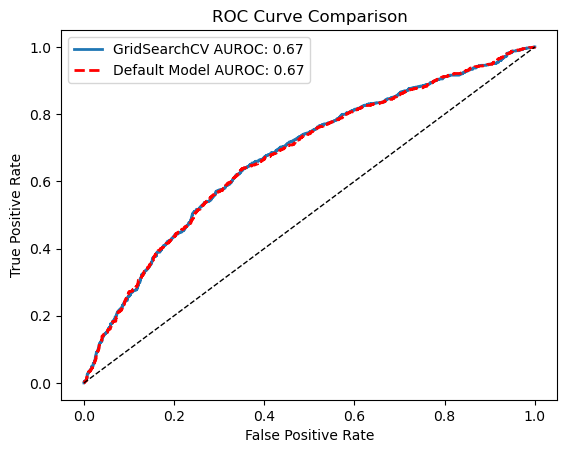

In [41]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load dataset
folder = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = "group_features_mw_fixed_sr.csv"
file_path = os.path.join(folder, file_name)
df = pd.read_csv(file_path)

# Define features
features = [
        "norm_fix_word_num", "norm_sacc_num", "norm_in_word_reg", "norm_out_word_reg",
        "zscored_zipf_fixdur_corr", "zscored_word_length_fixdur_corr",
        "norm_total_viewing", 'fix_dispersion', 
        'weighted_vergence', "pupil_slope", "norm_pupil"
    ]

df["label"] = df["is_MWreported"]
data = df.dropna(subset=features)

# Define LOSO cross-validation strategy
outer_logo = LeaveOneGroupOut()

# Define hyperparameter grid
param_grid = {
    "classifier__penalty": ["l2"],
    "classifier__C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__solver": ["lbfgs", "liblinear", "sag", "saga"]
}

# Extract features, labels, and subject IDs
X = data[features].values
y = data["label"].values
groups = data["sub_id"].values

# Initialize lists to store results
acc_scores, f1_scores, recall_scores, auroc_scores = [], [], [], []
all_confusion_matrices, true_labels, predicted_probs = [], [], []
best_params_foldwise = []
# Store predicted probabilities for the default model
default_predicted_probs = [] 

# Outer LOSO cross-validation loop with progress bar
for train_idx, test_idx in tqdm(outer_logo.split(X, y, groups), total=len(set(groups)), desc="Outer LOSO CV Progress"):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    groups_train = groups[train_idx]

    # Default Model (without hyperparameter tuning)
    default_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression())  # Default parameters
    ])
    default_pipeline.fit(X_train, y_train)
    default_predicted_probs.extend(default_pipeline.predict_proba(X_test)[:, 1])  # Store probabilities

    # Standardization & Classification Pipeline
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression())
    ])

    # Inner LOSO Grid Search for Hyperparameter Tuning
    inner_logo = LeaveOneGroupOut()
    grid = GridSearchCV(pipeline, param_grid, scoring="roc_auc", cv=inner_logo, return_train_score=True, verbose=0)
    grid.fit(X_train, y_train, groups=groups_train)

    # Store best parameters for this fold
    best_params_foldwise.append(grid.best_params_)
    print(grid.best_params_)

    # Get the best model from Grid Search
    best_model = grid.best_estimator_

    # Get predictions
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    y_pred = best_model.predict(X_test)

    # Compute metrics
    acc_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    auroc_scores.append(roc_auc_score(y_test, y_pred_prob))

    # Store confusion matrix, true labels, and predicted probabilities
    all_confusion_matrices.append(confusion_matrix(y_test, y_pred))
    true_labels.extend(y_test)
    predicted_probs.extend(y_pred_prob)


# Compute ROC curve and AUROC score for the tuned model
fpr_tuned, tpr_tuned, _ = roc_curve(true_labels, predicted_probs)
auroc_score_tuned = roc_auc_score(true_labels, predicted_probs)

# Compute ROC curve and AUROC score for the default model
fpr_default, tpr_default, _ = roc_curve(true_labels, default_predicted_probs)
auroc_score_default = roc_auc_score(true_labels, default_predicted_probs)

# Plot ROC curves for both models
plt.figure()
plt.plot(fpr_tuned, tpr_tuned, label=f"GridSearchCV AUROC: {auroc_score_tuned:.2f}", linewidth=2)
plt.plot(fpr_default, tpr_default, label=f"Default Model AUROC: {auroc_score_default:.2f}", linestyle="dashed", linewidth=2, color='r')
plt.plot([0, 1], [0, 1], "k--", linewidth=1)  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()



# Feature importance for MW-fixed

In [18]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.inspection import permutation_importance
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define features
features = [
    "norm_fix_word_num", "norm_in_word_reg", "norm_out_word_reg",
    "zscored_zipf_fixdur_corr", 'fix_dispersion',
    'weighted_vergence', "pupil_slope", "norm_pupil"
]

# Define function to run analysis
def run_feature_importance(base_name, label_col="is_MWreported", min_win_dur=0):
    path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
    file = f'group_features_{base_name}_sr.csv'
    df = pd.read_csv(os.path.join(path, file))
    if "win_dur" in df.columns and min_win_dur is not None:
        df = df[df['win_dur'] >= min_win_dur]

    df["label"] = df[label_col]
    data = df.dropna(subset=features)
    
    X = data[features].values
    y = data["label"].values
    groups = data["sub_id"].values

    logo = LeaveOneGroupOut()

    coef_list, A_list, perm_list = [], [], []

    for train_idx, test_idx in logo.split(X, y, groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", LogisticRegression())
        ])
        pipeline.fit(X_train, y_train)
        model = pipeline.named_steps['classifier']

        # Forward model
        w = model.coef_.flatten()
        Z = np.dot(X_test, w)
        A = np.dot(X_test.T, Z) / np.dot(Z.T, Z)
        A_list.append(A)

        # Coefficients
        coef_list.append(model.coef_[0])

        # Permutation importance
        perm_result = permutation_importance(pipeline, X_train, y_train)
        perm_list.append(perm_result['importances_mean'])

    # Convert to DataFrame
    df_A = pd.DataFrame(A_list, columns=features)
    df_A["metric"] = "forward_model"
    df_coef = pd.DataFrame(coef_list, columns=features)
    df_coef["metric"] = "coef"
    df_perm = pd.DataFrame(perm_list, columns=features)
    df_perm["metric"] = "permutation"

    df_importances = pd.concat([df_A, df_coef, df_perm], ignore_index=True)

    # Save to CSV
    df_importances.to_csv(os.path.join(path, f"{base_name}_feature_importance.csv"), index=False)

# Files to process
base_names = [
    "end2",
    "end5",
    "mw_fixed",
    "page_fixed"
]

# Run for each
for base_name in base_names:
    run_feature_importance(base_name)


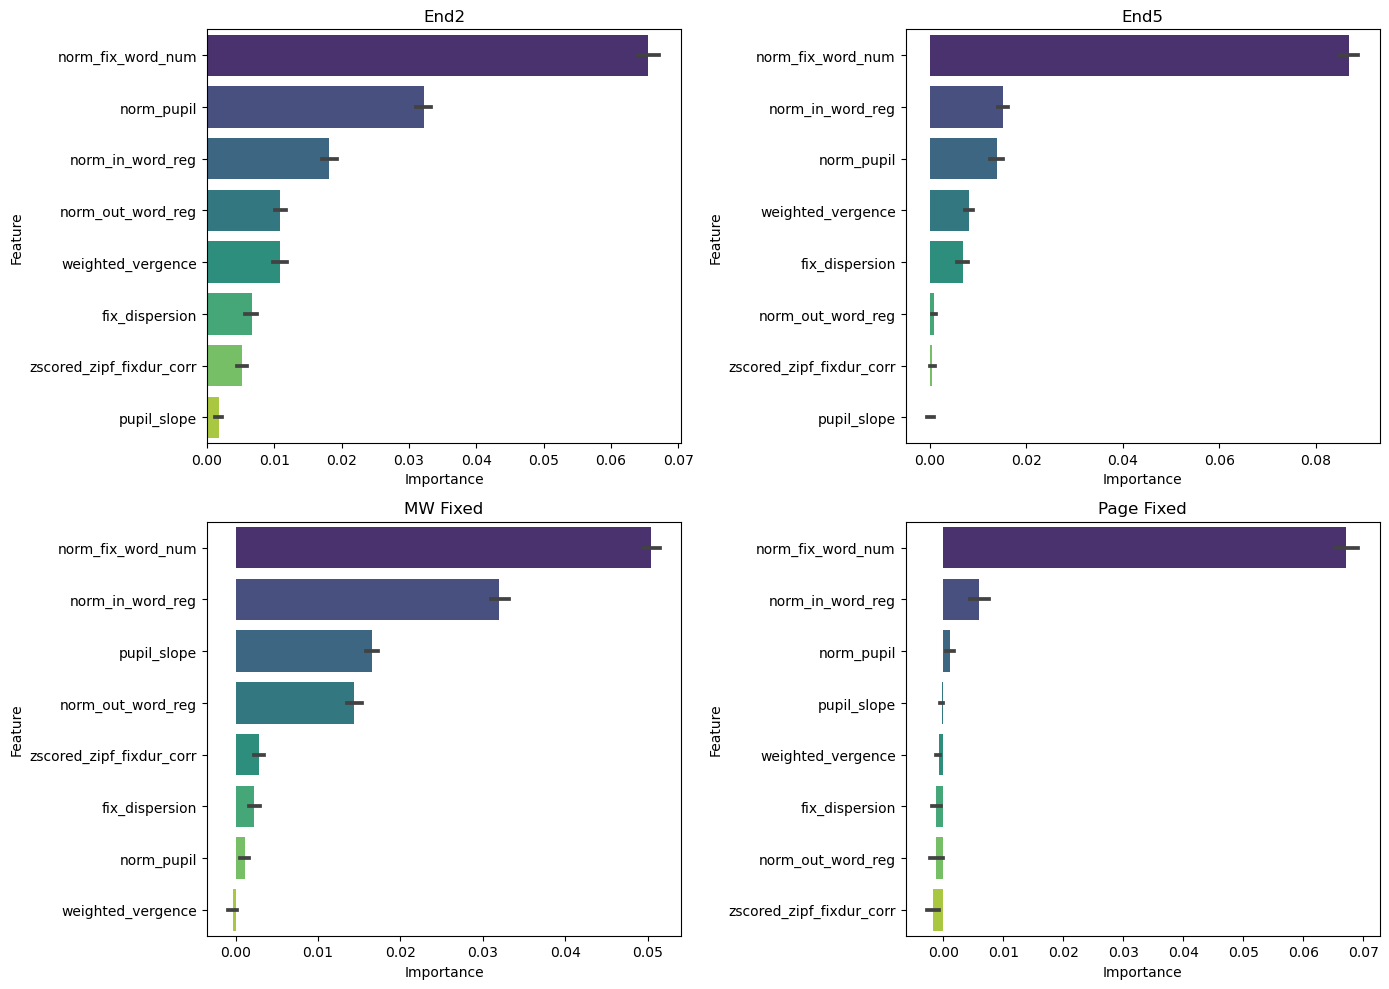

In [19]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

base_path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
files = [
    "end2_feature_importance.csv",
    "end5_feature_importance.csv",
    "mw_fixed_feature_importance.csv",
    "page_fixed_feature_importance.csv"
]
titles = ["End2", "End5", "MW Fixed", "Page Fixed"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, (file, title) in enumerate(zip(files, titles)):
    df = pd.read_csv(os.path.join(base_path, file))
    df = df[df['metric'] == 'permutation']
    
    df_long = df.drop(columns=['metric']).melt(var_name='Feature', value_name='Importance')
    order = df_long.groupby('Feature')['Importance'].mean().sort_values(ascending=False).index

    sns.barplot(
        data=df_long, 
        x='Importance', 
        y='Feature', 
        order=order, 
        palette='viridis', 
        ax=axs[i]
    )
    axs[i].set_title(title)
    axs[i].set_xlabel("Importance")
    axs[i].set_ylabel("Feature")

plt.tight_layout()
plt.show()

# Downsample sliding window features

In [20]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import resample

# === Load Data ===
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = "group_features_slide2.0.csv"
df = pd.read_csv(os.path.join(path, file_name))

df_downsample = pd.DataFrame()

# === Filter based on window alignment ===
alpha = 2
df = df[df['page_end'] - df['win_end'] >= alpha].copy()
df['relative_time'] = df['relative_time'].round(4)

# Define features
features = [
        "norm_fix_word_num", "norm_in_word_reg", "norm_out_word_reg",
        "zscored_zipf_fixdur_corr", 'fix_dispersion', 
        'weighted_vergence', "pupil_slope", "norm_pupil"
    ]
# drop rows containing Nan
df = df.dropna(subset=features)

# ==================================== MW onset ====================================
control = 'control_onset'
target = 'MW_onset'

required_labels = {control, target}

# === Select only relevant labels and compute unique timepoints ===
df_cond = df[df['label'].isin(required_labels)].copy()
time_points = np.sort(df_cond['relative_time'].unique())
subjects = df_cond['sub_id'].unique()

sub_dict_onset = {}  # To store min class-balanced sample size per subject
final_sample_size = 0

# loop over all subjects
for sub in subjects:
    min_control, min_target = np.inf, np.inf
    has_sample = True
    # loop over all time points
    for time in time_points:
        df_time = df_cond[df_cond['relative_time'] == time]
        control_n = np.sum((df_time['sub_id'] == sub) & (df_time['label'] == control))
        target_n = np.sum((df_time['sub_id'] == sub) & (df_time['label'] == target))

        # update the minimum across timepoints
        if control_n > 0 and target_n > 0:  # only consider if both classes exist
            min_control = min(min_control, control_n)
            min_target = min(min_target, target_n)
        else:
            has_sample = False

    if has_sample:
        sub_dict_onset[sub] = (min_control, min_target)
        final_sample_size += min_control + min_target

for time in time_points:
    df_time = df_cond[df_cond['relative_time'] == time]
    df_time_downsampled = []

    for sub, (n_control, n_target) in sub_dict_onset.items():

        df_sub = df_time[df_time['sub_id'] == sub]
        df_control = df_sub[df_sub['label'] == control]
        df_target = df_sub[df_sub['label'] == target]

        # Downsample
        sampled_control = resample(df_control, replace=False, n_samples=n_control, random_state=42)
        sampled_target = resample(df_target, replace=False, n_samples=n_target, random_state=42)

        df_time_downsampled.extend([sampled_control, sampled_target])

    data = pd.concat(df_time_downsampled, ignore_index=True)
    df_downsample = pd.concat([df_downsample, data], ignore_index=True)


# ==================================== self-report ====================================
control = 'control_sr'
target = 'self_report'

required_labels = {control, target}

# === Select only relevant labels and compute unique timepoints ===
df_cond = df[df['label'].isin(required_labels)].copy()
time_points = np.sort(df_cond['relative_time'].unique())
subjects = df_cond['sub_id'].unique()

sub_dict_sr = {}  # To store min class-balanced sample size per subject
final_sample_size = 0

# loop over all subjects
for sub in subjects:
    min_control, min_target = np.inf, np.inf
    has_sample = True
    # loop over all time points
    for time in time_points:
        df_time = df_cond[df_cond['relative_time'] == time]
        control_n = np.sum((df_time['sub_id'] == sub) & (df_time['label'] == control))
        target_n = np.sum((df_time['sub_id'] == sub) & (df_time['label'] == target))

        # update the minimum across timepoints
        if control_n > 0 and target_n > 0:  # only consider if both classes exist
            min_control = min(min_control, control_n)
            min_target = min(min_target, target_n)
        else:
            has_sample = False

    if has_sample:
        sub_dict_sr[sub] = (min_control, min_target)
        final_sample_size += min_control + min_target


for time in time_points:
    df_time = df_cond[df_cond['relative_time'] == time]
    df_time_downsampled = []

    for sub, (n_control, n_target) in sub_dict_sr.items():

        df_sub = df_time[df_time['sub_id'] == sub]
        df_control = df_sub[df_sub['label'] == control]
        df_target = df_sub[df_sub['label'] == target]

        # Downsample
        sampled_control = resample(df_control, replace=False, n_samples=n_control, random_state=42)
        sampled_target = resample(df_target, replace=False, n_samples=n_target, random_state=42)

        df_time_downsampled.extend([sampled_control, sampled_target])

    data = pd.concat(df_time_downsampled, ignore_index=True)
    df_downsample = pd.concat([df_downsample, data], ignore_index=True)


file_to_save = "group_features_slide_downsample.csv"
df_downsample.to_csv(os.path.join(path, file_to_save), index=False)


# Deconding accuracy for sliding window features

In [21]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, f1_score, recall_score, accuracy_score

# load data
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = "group_features_slide_downsample.csv"
df = pd.read_csv(os.path.join(path, file_name))
subjects = df['sub_id'].unique()
features = [
        "norm_fix_word_num", "norm_in_word_reg", "norm_out_word_reg",
        "zscored_zipf_fixdur_corr", 'fix_dispersion', 
        'weighted_vergence', "pupil_slope", "norm_pupil"
    ]
n_permutations = 200

# ======================================= MW onset =======================================
control = 'control_onset'
target = 'MW_onset'
required_labels = {control, target}
df_cond = df[df['label'].isin(required_labels)].copy()
df_cond['ml_label'] = df_cond['label'] == target
time_points = np.sort(df_cond['relative_time'].unique())

# =================== Permutation Test ===================
perm_auroc_scores = []
perm_time_point = []
perm_iteration = []

for time in tqdm(time_points, desc=f'{target} permutation test'):
    df_time = df_cond[df_cond['relative_time']==time]

    for iteration in range(n_permutations):
        perm_data = pd.DataFrame()
        # shuffle the dataset by resampling with replacement
        for sub in subjects:
            df_control = df_time[(df_time['sub_id']==sub) & (df_time['label']==control)]
            df_target = df_time[(df_time['sub_id']==sub) & (df_time['label']==target)]
            perm_control = resample(df_control, replace=True, n_samples=len(df_control), random_state=iteration)
            perm_target = resample(df_target, replace=True, n_samples=len(df_target), random_state=iteration)
            # change the subject ID for LOSO
            perm_data_sub = pd.concat([perm_control, perm_target], ignore_index=True)
            perm_data_sub['sub_id'] = sub
            # save shuffled dataset
            perm_data = pd.concat([perm_data, perm_data_sub])
        
        # Extract features, labels, and subject IDs
        data = perm_data
        X = data[features].values
        y = data["ml_label"].values
        groups = data["sub_id"].values

        # Prepare the cross-validation strategy (Leave-One-Subject-Out)
        logo = LeaveOneGroupOut()

        true_labels, predicted_probs = [], []
        # Leave-one-subject-out cross-validation
        for train_idx, test_idx in logo.split(X, y, groups):
            # split training and testing dataset
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Default Model (without hyperparameter tuning)
            pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ("classifier", LogisticRegression())  # Default parameters
            ])
            pipeline.fit(X_train, y_train)

            y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
            y_pred = pipeline.predict(X_test)

            model = pipeline.named_steps['classifier']

            # Store confusion matrix, true labels, and predicted probabilities
            true_labels.extend(y_test)
            predicted_probs.extend(y_pred_prob)

        # save permutation test results
        perm_auroc_scores.append(roc_auc_score(true_labels, predicted_probs))
        perm_time_point.append(time)
        perm_iteration.append(iteration+1)
# =================== Permutation Test END ===================

# Initialize lists to store results
subject_list, time_list = [], []
acc_scores, f1_scores, recall_scores, auroc_scores = [], [], [], []
overall_auroc_scores = []

for time in time_points:
    data = df_cond[df_cond['relative_time'] == time]

    # Extract features, labels, and subject IDs
    X = data[features].values
    y = data["ml_label"].values
    groups = data["sub_id"].values

    # Prepare the cross-validation strategy (Leave-One-Subject-Out)
    logo = LeaveOneGroupOut()

    true_labels, predicted_probs = [], []
    # Leave-one-subject-out cross-validation
    for train_idx, test_idx in logo.split(X, y, groups):
        test_subject = groups[test_idx][0]
        # record information
        subject_list.append(test_subject)
        time_list.append(time)

        # split training and testing dataset
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Default Model (without hyperparameter tuning)
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", LogisticRegression())  # Default parameters
        ])
        pipeline.fit(X_train, y_train)

        y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
        y_pred = pipeline.predict(X_test)

        model = pipeline.named_steps['classifier']

        # Compute metrics
        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        auroc_scores.append(roc_auc_score(y_test, y_pred_prob))

        # Store confusion matrix, true labels, and predicted probabilities
        true_labels.extend(y_test)
        predicted_probs.extend(y_pred_prob)

    perm_auroc_scores.append(roc_auc_score(true_labels, predicted_probs))
    perm_time_point.append(time)
    perm_iteration.append(0)

df_perm_onset = pd.DataFrame({
    "condition": "MW_onset",
    "time": perm_time_point,
    "iteration": perm_iteration,
    "auroc": perm_auroc_scores
})


# ======================================= self-report =======================================
control = 'control_sr'
target = 'self_report'
required_labels = {control, target}
df_cond = df[df['label'].isin(required_labels)].copy()
df_cond['ml_label'] = df_cond['label'] == target
time_points = np.sort(df_cond['relative_time'].unique())

# =================== Permutation Test ===================
perm_auroc_scores = []
perm_time_point = []
perm_iteration = []

for time in tqdm(time_points, desc=f'{target} permutation test'):
    df_time = df_cond[df_cond['relative_time']==time]

    for iteration in range(n_permutations):
        perm_data = pd.DataFrame()
        # shuffle the dataset by resampling with replacement
        for sub in subjects:
            df_control = df_time[(df_time['sub_id']==sub) & (df_time['label']==control)]
            df_target = df_time[(df_time['sub_id']==sub) & (df_time['label']==target)]
            perm_control = resample(df_control, replace=True, n_samples=len(df_control), random_state=iteration)
            perm_target = resample(df_target, replace=True, n_samples=len(df_target), random_state=iteration)
            # change the subject ID for LOSO
            perm_data_sub = pd.concat([perm_control, perm_target], ignore_index=True)
            perm_data_sub['sub_id'] = sub
            # save shuffled dataset
            perm_data = pd.concat([perm_data, perm_data_sub])
        
        # Extract features, labels, and subject IDs
        data = perm_data
        X = data[features].values
        y = data["ml_label"].values
        groups = data["sub_id"].values

        # Prepare the cross-validation strategy (Leave-One-Subject-Out)
        logo = LeaveOneGroupOut()

        true_labels, predicted_probs = [], []
        # Leave-one-subject-out cross-validation
        for train_idx, test_idx in logo.split(X, y, groups):
            # split training and testing dataset
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Default Model (without hyperparameter tuning)
            pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ("classifier", LogisticRegression())  # Default parameters
            ])
            pipeline.fit(X_train, y_train)

            y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
            y_pred = pipeline.predict(X_test)

            model = pipeline.named_steps['classifier']

            # Store confusion matrix, true labels, and predicted probabilities
            true_labels.extend(y_test)
            predicted_probs.extend(y_pred_prob)

        # save permutation test results
        perm_auroc_scores.append(roc_auc_score(true_labels, predicted_probs))
        perm_time_point.append(time)
        perm_iteration.append(iteration+1)
# =================== Permutation Test END ===================

# Initialize lists to store results
subject_list, time_list = [], []
acc_scores, f1_scores, recall_scores, auroc_scores = [], [], [], []
overall_auroc_scores = []

for time in time_points:
    data = df_cond[df_cond['relative_time'] == time]

    # Extract features, labels, and subject IDs
    X = data[features].values
    y = data["ml_label"].values
    groups = data["sub_id"].values

    # Prepare the cross-validation strategy (Leave-One-Subject-Out)
    logo = LeaveOneGroupOut()

    true_labels, predicted_probs = [], []
    # Leave-one-subject-out cross-validation
    for train_idx, test_idx in logo.split(X, y, groups):
        test_subject = groups[test_idx][0]
        # record information
        subject_list.append(test_subject)
        time_list.append(time)

        # split training and testing dataset
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Default Model (without hyperparameter tuning)
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", LogisticRegression())  # Default parameters
        ])
        pipeline.fit(X_train, y_train)

        y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
        y_pred = pipeline.predict(X_test)

        model = pipeline.named_steps['classifier']

        # Compute metrics
        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        auroc_scores.append(roc_auc_score(y_test, y_pred_prob))

        # Store confusion matrix, true labels, and predicted probabilities
        true_labels.extend(y_test)
        predicted_probs.extend(y_pred_prob)

    perm_auroc_scores.append(roc_auc_score(true_labels, predicted_probs))
    perm_time_point.append(time)
    perm_iteration.append(0)

# Combine MW onset permutation results
df_perm_sr = pd.DataFrame({
    "condition": "self_report",
    "time": perm_time_point,
    "iteration": perm_iteration,
    "auroc": perm_auroc_scores
})

df_perm_all = pd.concat([df_perm_onset, df_perm_sr], ignore_index=True)
# Save
df_perm_all.to_csv(os.path.join(path, "deconding_acc_around_events.csv"), index=False)


self_report permutation test: 100%|██████████| 21/21 [18:22<00:00, 52.49s/it]


# Raw scores over time points

In [22]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, f1_score, recall_score, accuracy_score

# load data
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = "group_features_slide_downsample.csv"
df = pd.read_csv(os.path.join(path, file_name))
subjects = df['sub_id'].unique()
features = [
        "norm_fix_word_num", "norm_in_word_reg", "norm_out_word_reg",
        "zscored_zipf_fixdur_corr", 'fix_dispersion', 
        'weighted_vergence', "pupil_slope", "norm_pupil"
    ]
X_all = df[features].values

df_final = pd.DataFrame()

# ======================================= MW onset 0s =======================================
classifier_type = 'onset0'
control = 'control_onset'
target = 'MW_onset'
required_labels = {control, target}
df_cond = df[df['label'].isin(required_labels)].copy()
df_cond['ml_label'] = df_cond['label'] == target
data = df_cond[df_cond['relative_time']==0]

# Extract features, labels, and subject IDs
X = data[features].values
y = data["ml_label"].values

# Default Model (without hyperparameter tuning)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression())  # Default parameters
])
pipeline.fit(X, y)

y_pred_prob = pipeline.predict_proba(X_all)[:, 1]

df_ = pd.DataFrame({'sub_id': df['sub_id'],
                    'label': df['label'],
                    'time': df['relative_time'],
                    'pred_prob': y_pred_prob
                    })
df_['classifier'] = classifier_type
df_final = pd.concat([df_final, df_], ignore_index=True)


# ======================================= MW onset 5s =======================================
classifier_type = 'onset5'
control = 'control_onset'
target = 'MW_onset'
required_labels = {control, target}
df_cond = df[df['label'].isin(required_labels)].copy()
df_cond['ml_label'] = df_cond['label'] == target
data = df_cond[df_cond['relative_time']==5]

# Extract features, labels, and subject IDs
X = data[features].values
y = data["ml_label"].values

# Default Model (without hyperparameter tuning)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression())  # Default parameters
])
pipeline.fit(X, y)

y_pred_prob = pipeline.predict_proba(X_all)[:, 1]

df_ = pd.DataFrame({'sub_id': df['sub_id'],
                    'label': df['label'],
                    'time': df['relative_time'],
                    'pred_prob': y_pred_prob
                    })
df_['classifier'] = classifier_type
df_final = pd.concat([df_final, df_], ignore_index=True)


# ======================================= self-report 4s =======================================
classifier_type = 'sr4'
control = 'control_sr'
target = 'self_report'
required_labels = {control, target}
df_cond = df[df['label'].isin(required_labels)].copy()
df_cond['ml_label'] = df_cond['label'] == target
data = df_cond[df_cond['relative_time']==-4]

# Extract features, labels, and subject IDs
X = data[features].values
y = data["ml_label"].values

# Default Model (without hyperparameter tuning)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression())  # Default parameters
])
pipeline.fit(X, y)

y_pred_prob = pipeline.predict_proba(X_all)[:, 1]

df_ = pd.DataFrame({'sub_id': df['sub_id'],
                    'label': df['label'],
                    'time': df['relative_time'],
                    'pred_prob': y_pred_prob
                    })
df_['classifier'] = classifier_type
df_final = pd.concat([df_final, df_], ignore_index=True)

# save df to the Files folder
df_final.to_csv(os.path.join(path, "pred_prob.csv"), index=False)


# Prepare the cross-validation strategy (Leave-One-Subject-Out)
# logo = LeaveOneGroupOut()
# groups = data["sub_id"].values

# # Leave-one-subject-out cross-validation
# for train_idx, test_idx in logo.split(X, y, groups):
#     test_subject = groups[test_idx][0]
#     # record information

#     # split training and testing dataset
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]

#     # Default Model (without hyperparameter tuning)
#     pipeline = Pipeline([
#         ("scaler", StandardScaler()),
#         ("classifier", LogisticRegression())  # Default parameters
#     ])
#     pipeline.fit(X_train, y_train)

#     # get the data from other subjects for getting the pred prob
#     df_ = df[df['sub_id'] != test_subject]
#     X_test = df_[features].values

#     y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    
#     df_temp = pd.DataFrame({'sub_id': df_['sub_id'],
#                             'label': df_['label'],
#                             'pred_prob': y_pred_prob
#                             })
#     df_temp['classifier'] = classifier_type
#     df_final = pd.concat([df_final, df_temp], ignore_index=True)



# Feature importance for three classifiers

In [2]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# load data
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = "group_features_slide5_downsample.csv"
df = pd.read_csv(os.path.join(path, file_name))
subjects = df['sub_id'].unique()
features = [
    "norm_fix_word_num", "norm_sacc_num", "norm_in_word_reg", "norm_out_word_reg",
    "zscored_zipf_fixdur_corr", "zscored_word_length_fixdur_corr",
    "norm_total_viewing", 'fix_dispersion', 
    'weighted_vergence', "pupil_slope", "norm_pupil"
]
X_all = df[features].values

df_final = pd.DataFrame()

# ======================================= MW onset 0s =======================================
classifier_type = 'onset0'
control = 'control_onset'
target = 'MW_onset'
required_labels = {control, target}
df_cond = df[df['label'].isin(required_labels)].copy()
df_cond['ml_label'] = df_cond['label'] == target
data = df_cond[df_cond['relative_time']==0]

# Extract features, labels, and subject IDs
X = data[features].values
y = data["ml_label"].values

# Default Model (without hyperparameter tuning)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression())  # Default parameters
])
pipeline.fit(X, y)

# permutation importance
model_fi = permutation_importance(pipeline, X, y)

# Save to DataFrame
df_ = pd.DataFrame({
    "feature": features,
    "mean_importance": model_fi["importances_mean"],
    "std_importance": model_fi["importances_std"]
})

df_['classifier'] = classifier_type
df_final = pd.concat([df_final, df_], ignore_index=True)


# ======================================= MW onset 5s =======================================
classifier_type = 'onset5'
control = 'control_onset'
target = 'MW_onset'
required_labels = {control, target}
df_cond = df[df['label'].isin(required_labels)].copy()
df_cond['ml_label'] = df_cond['label'] == target
data = df_cond[df_cond['relative_time']==5]

# Extract features, labels, and subject IDs
X = data[features].values
y = data["ml_label"].values

# Default Model (without hyperparameter tuning)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression())  # Default parameters
])
pipeline.fit(X, y)

# permutation importance
model_fi = permutation_importance(pipeline, X, y)

# Save to DataFrame
df_ = pd.DataFrame({
    "feature": features,
    "mean_importance": model_fi["importances_mean"],
    "std_importance": model_fi["importances_std"]
})

df_['classifier'] = classifier_type
df_final = pd.concat([df_final, df_], ignore_index=True)



# ======================================= self-report 4s =======================================
classifier_type = 'sr4'
control = 'control_sr'
target = 'self_report'
required_labels = {control, target}
df_cond = df[df['label'].isin(required_labels)].copy()
df_cond['ml_label'] = df_cond['label'] == target
data = df_cond[df_cond['relative_time']==-4]

# Extract features, labels, and subject IDs
X = data[features].values
y = data["ml_label"].values

# Default Model (without hyperparameter tuning)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression())  # Default parameters
])
pipeline.fit(X, y)

# permutation importance
model_fi = permutation_importance(pipeline, X, y)

# Save to DataFrame
df_ = pd.DataFrame({
    "feature": features,
    "mean_importance": model_fi["importances_mean"],
    "std_importance": model_fi["importances_std"]
})

df_['classifier'] = classifier_type
df_final = pd.concat([df_final, df_], ignore_index=True)


# save df to the Files folder
df_final.to_csv(os.path.join(path, "feature_importance_slidingwindow.csv"), index=False)

